In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# load data
df = pd.read_excel("../data/raw/Telco_customer_churn_adapted_v2.xlsx")
df_ori = df.copy()

In [3]:
df_ori.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer ID,7043.0,3521.000000,2033.283305,0.000000,1760.500000,3521.000000,5281.50000,7042.00000
Tenure Months,7043.0,32.371149,24.559481,0.000000,9.000000,29.000000,55.00000,72.00000
Monthly Purchase (Thou. IDR),7043.0,84.190200,39.117061,23.725000,46.150000,91.455000,116.80500,154.37500
Longitude,7043.0,107.043246,0.358316,106.816666,106.816666,106.816666,107.60981,107.60981
Latitude,7043.0,-6.404184,0.322898,-6.914744,-6.914744,-6.200000,-6.20000,-6.20000
CLTV (Predicted Thou. IDR),7043.0,5720.384481,1537.974298,2603.900000,4509.700000,5885.100000,6994.65000,8450.00000


In [4]:
df_ori.describe(exclude="number").T

,count,unique,top,freq
Location,7043,2,Jakarta,5031
Device Class,7043,3,High End,3096
Games Product,7043,3,No,3498
Music Product,7043,3,No,3088
Education Product,7043,3,No,3095
Call Center,7043,2,No,4999
Video Product,7043,3,No,2810
Use MyApp,7043,3,No,2785
Payment Method,7043,4,Pulsa,2365
Churn Label,7043,2,No,5174


In [173]:
df_ori.shape

(7043, 16)

# Background

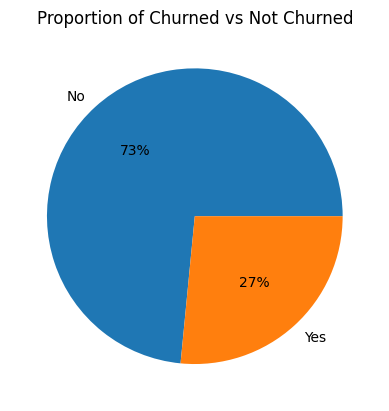

In [174]:
plot_df = df['Churn Label'].value_counts(normalize=True)*100
plt.pie(plot_df, labels=plot_df.index, autopct='%.0f%%')
plt.title("Proportion of Churned vs Not Churned")
plt.show()

27% of passengers churned from purchasing

In [175]:
display(df.groupby("Churn Label")["CLTV (Predicted Thou. IDR)"].sum())
display(df.groupby("Churn Label")["Monthly Purchase (Thou. IDR)"].sum())

Churn Label
No     30206835.1
Yes    10081832.8
Name: CLTV (Predicted Thou. IDR), dtype: float64

Churn Label
No     412081.475
Yes    180870.105
Name: Monthly Purchase (Thou. IDR), dtype: float64

Around `Rp10,081,832,800.00` potential income in the future gone.

Around `Rp180,870,800.00` stripped out from the company's monthly income.

# EDA

## Univariate

### Original

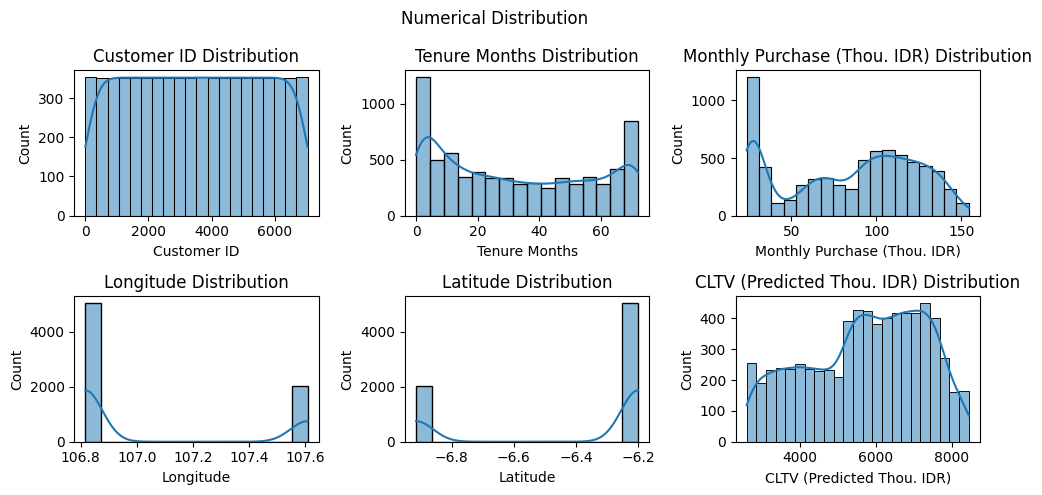

In [176]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.suptitle("Numerical Distribution")
fig.tight_layout()

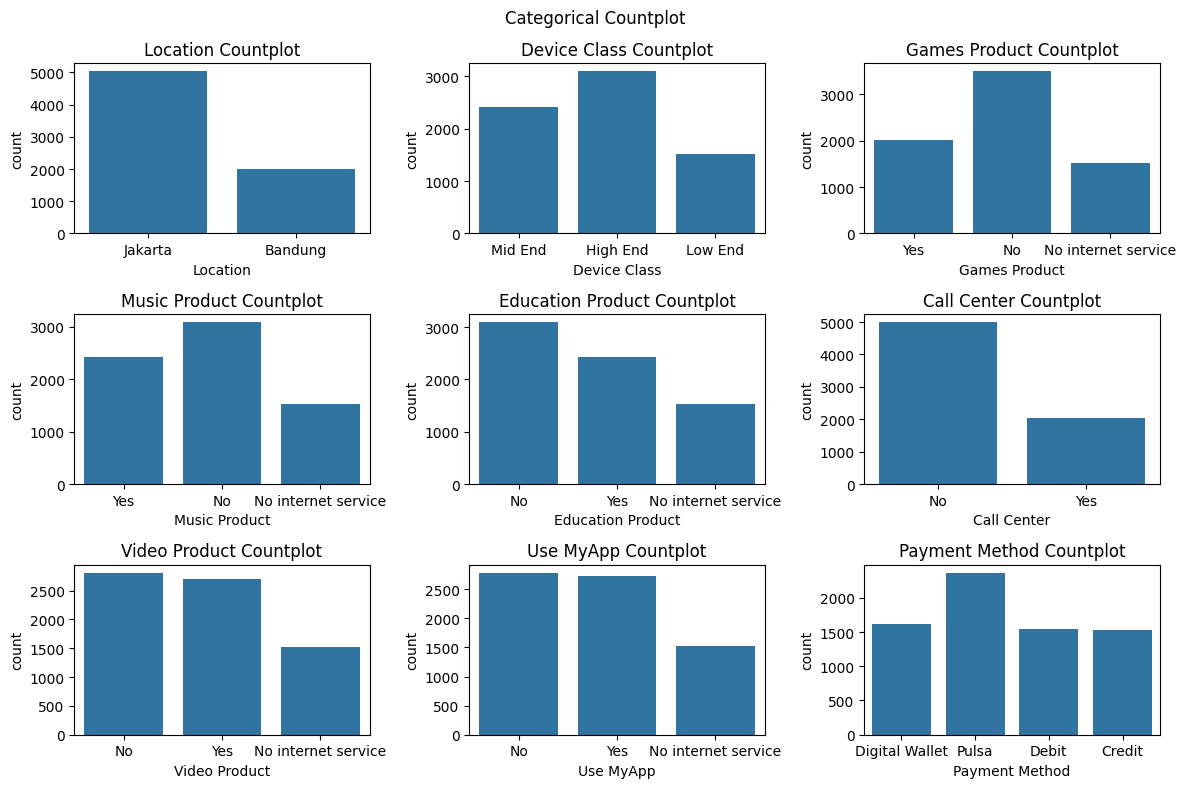

In [177]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.suptitle("Categorical Countplot")
fig.tight_layout()

### Hue `Churn Label`

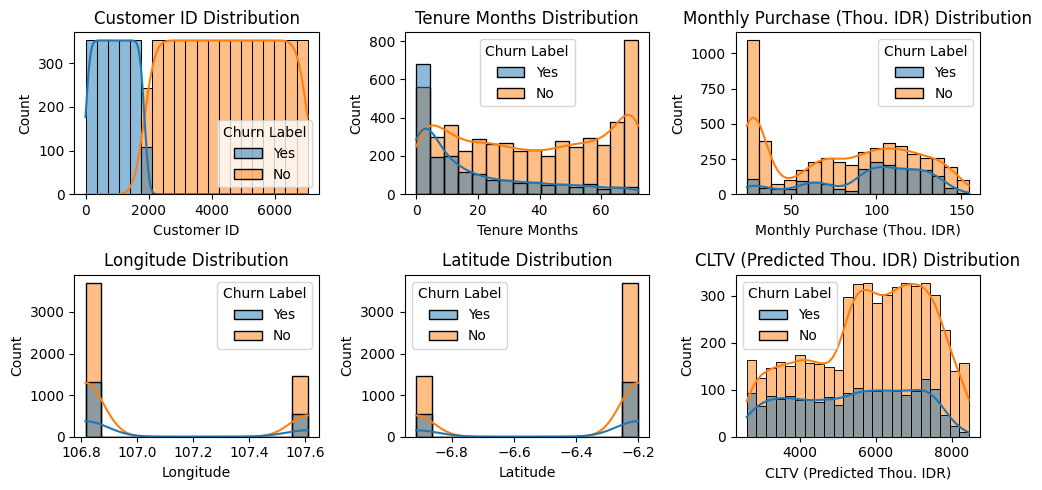

In [178]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(10, 5))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.histplot(data=df, x=numerical_columns[i], hue="Churn Label", kde=True, ax=col)
        col.set_title(f"{numerical_columns[i]} Distribution")
        i+=1
fig.tight_layout()

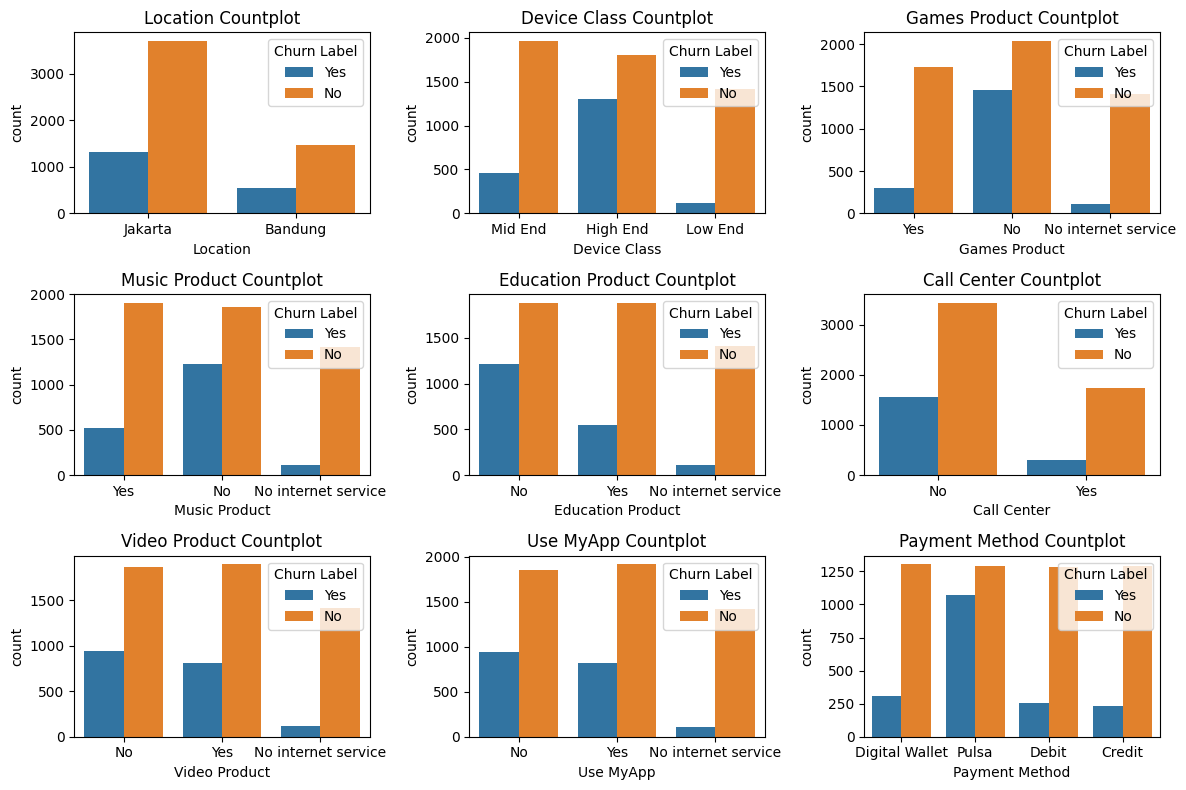

In [179]:
numerical_columns = df.select_dtypes(include=[object]).columns
fig, ax = plt.subplots(nrows=int(len(numerical_columns)//3), ncols=3, figsize=(12, 8))

i = 0 # for accessing array of column names
for rows in ax: # access rows of subplots
    for col in rows: # access column inside subplot rows
        sns.countplot(data=df,x=numerical_columns[i], hue='Churn Label', ax=col)
        col.set_title(f"{numerical_columns[i]} Countplot")
        i+=1
fig.tight_layout()

### Skew

In [180]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    skewness = df[col].skew()
    if skewness < -0.5: 
        print(f"{col}, skewness: {skewness}, left skewed")
    elif skewness > 0.5: 
        print(f"{col}, skewness: {skewness}, right skewed")
    else: 
        print(f"{col}, skewness: {skewness}, approximately symmetric")

Customer ID, skewness: 0.0, approximately symmetric
Tenure Months, skewness: 0.2395397495619829, approximately symmetric
Monthly Purchase (Thou. IDR), skewness: -0.2205244339439807, approximately symmetric
Longitude, skewness: 0.9491054700666193, right skewed
Latitude, skewness: -0.9491054700664001, left skewed
CLTV (Predicted Thou. IDR), skewness: -0.3116021004049805, approximately symmetric


### Kurtosis

In [181]:
numerical_columns = df.select_dtypes(include=[int, float]).columns
for col in numerical_columns:
    kurtosis = df[col].kurtosis()
    if kurtosis > 3:
        print(f"{col}, kurtosis: {kurtosis}, leptokurtic (heavy tailed, more chance of outliers)")
    elif kurtosis < 3:
        print(f"{col}, kurtosis: {kurtosis}, platykurtic")
    else:
        print(f"{col}, kurtosis: {kurtosis}, mesokurtic")

Customer ID, kurtosis: -1.1999999999999997, platykurtic
Tenure Months, kurtosis: -1.3873716359716848, platykurtic
Monthly Purchase (Thou. IDR), kurtosis: -1.2572596945495054, platykurtic
Longitude, kurtosis: -1.099511115413302, platykurtic
Latitude, kurtosis: -1.0995111154135797, platykurtic
CLTV (Predicted Thou. IDR), kurtosis: -0.9340324830072797, platykurtic


## Device Class

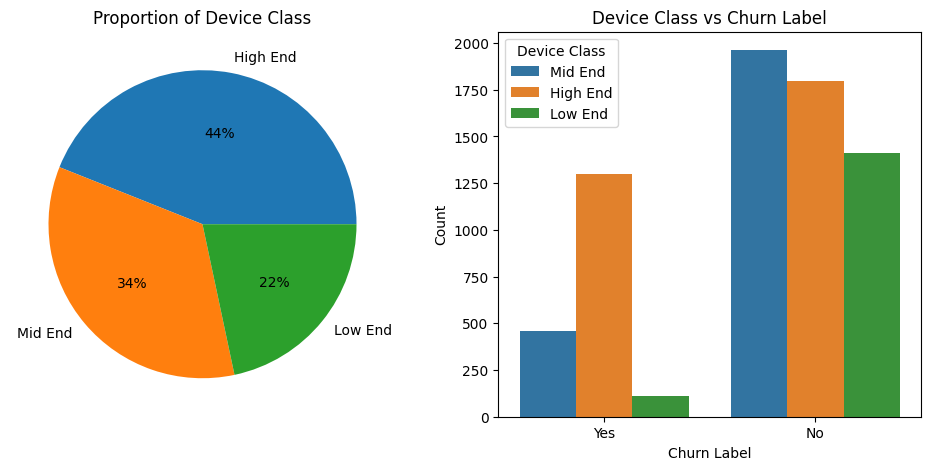

In [182]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Device Class
# =================================================================
plot_df = df["Device Class"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Device Class")

# Device Class vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Device Class', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Device Class vs Churn Label")
plt.show()

1. `~1250` customer who churned are from the high end class followed by mid (`~500`) and low (`~125`) end class. From this data higher end devices resulted in more likely to churn.
2. The proportion is dominated by **High End**, followed by **Mid End** and **Low End**

## Location

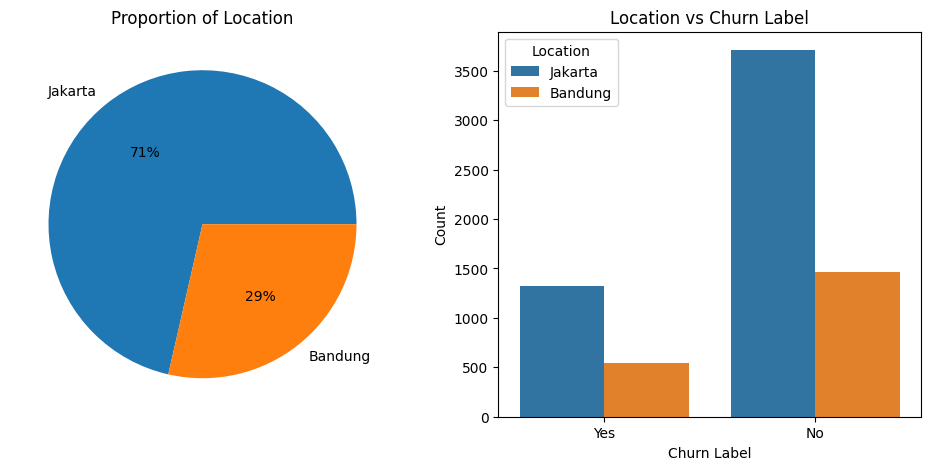

In [183]:
fig, ax = plt.subplots(figsize=(12, 5), ncols=2)

# Proportion of the Location
# =================================================================
plot_df = df["Location"].value_counts(normalize=True) * 100
ax[0].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
ax[0].set_title("Proportion of Location")

# Location vs Churn Label
# =================================================================
sns.countplot(data=df, x='Churn Label', hue='Location', ax=ax[1])
ax[1].set(xlabel = "Churn Label", ylabel="Count", title="Location vs Churn Label")
plt.show()

In [184]:
location_churn = df.pivot_table(values="Customer ID", index="Churn Label", columns="Location", aggfunc="count", margins=True)
location_churn / location_churn.loc["All", :]

Location,Bandung,Jakarta,All
Churn Label,,,
No,0.728628,0.73703,0.73463
Yes,0.271372,0.26297,0.26537
All,1.000000,1.00000,1.00000


1. Jakarta has the highes churn rate, but It's due to inequality of proportion between users from **Jakarta** and **Bandung**
2. The changes of user either from `Bandung` and `Jakarta` are almost the same. 

## Games Product, Music Product, Education Product, Video Product, and Use MyApp
`No internet service` and `No` means the same thing which is the use doesn't use the internet for the specified **product** or **app**.

In [5]:
# change label of product and app
def preprocess_data(df):
    def check_internet_service(row): 
        if row['Games Product'] == "No internet service"\
            and row['Music Product'] == "No internet service"\
            and row['Education Product'] == "No internet service"\
            and row['Video Product'] == "No internet service"\
            and row['Use MyApp'] == "No internet service":
            return 0
        else: return 1
    
    df=df.copy()
    df['Internet Service'] = df.apply(lambda x: check_internet_service(x), axis=1)
    
    # prod_app_map = {
    #     "Yes": 1,
    #     "No": 0,
    #     "No internet service": 0,
    # }
    # df['Games Product'] = df['Games Product'].replace(prod_app_map)
    # df['Music Product'] = df['Music Product'].replace(prod_app_map)
    # df['Education Product'] = df['Education Product'].replace(prod_app_map)
    # df['Video Product'] = df['Video Product'].replace(prod_app_map)
    # df['Use MyApp'] = df['Use MyApp'].replace(prod_app_map)

    
    df['Churn'] = df['Churn Label'].map({"Yes": "1", "No": "0"}).astype(int)    
    df['Total Purchase'] = df['Tenure Months'] * df['Monthly Purchase (Thou. IDR)']
    return df

df = preprocess_data(df_ori)

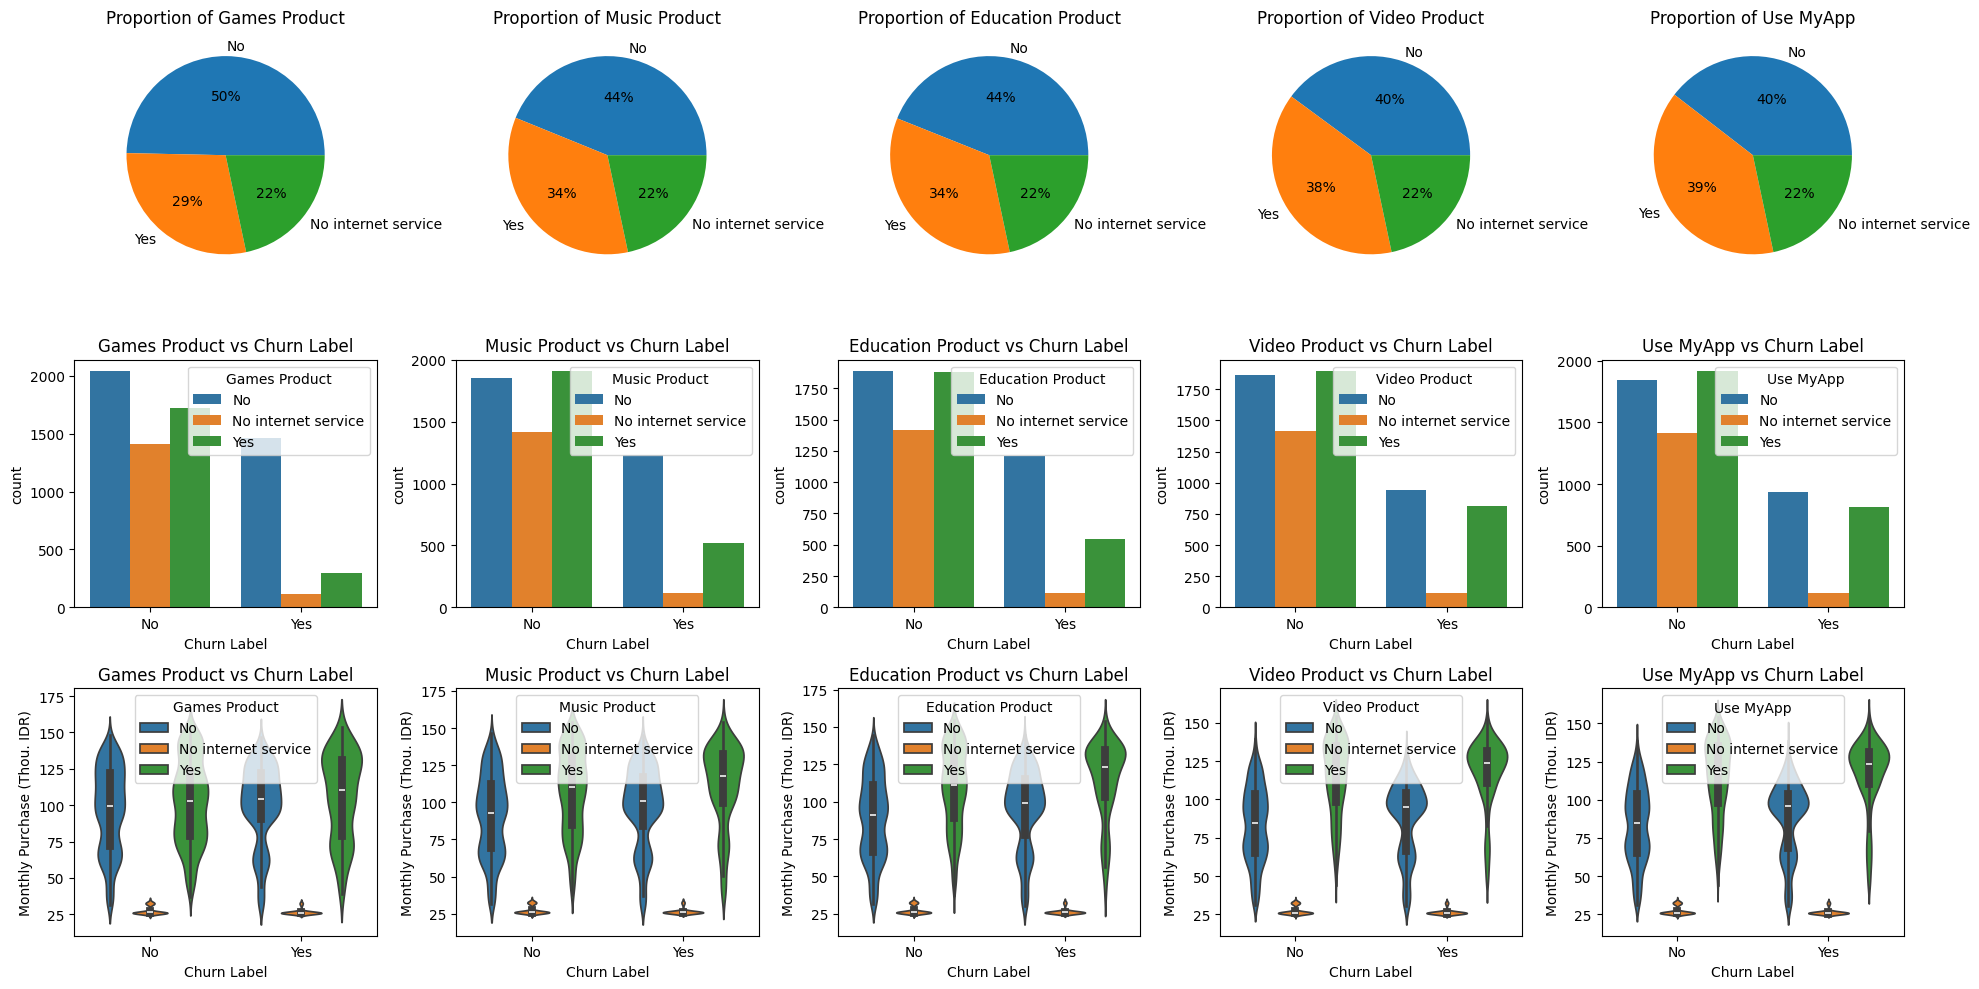

In [186]:

cols = ["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]
fig, ax = plt.subplots(nrows=3, ncols=len(cols), figsize=(20, 10))

for i, c in enumerate(cols):
    plot_df = df[c].value_counts(normalize=True) * 100
    ax[0][i].pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
    ax[0][i].set_title(f"Proportion of {c}")
    

for i, c in enumerate(cols):
    sns.countplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', hue=c, ax=ax[1][i])
    ax[1][i].set_title(f"{c} vs Churn Label")
    
    
for i, c in enumerate(cols):
    sns.violinplot(data=df.sort_values(by=[c, 'Churn Label']), x='Churn Label', y="Monthly Purchase (Thou. IDR)", hue=c, ax=ax[2][i])
    ax[2][i].set_title(f"{c} vs Churn Label")

fig.tight_layout()

1. People who didn't use internet service for Games, Music, and Education Product has a higher change of churn.
2. People who's monthly purchase is around **100K** and didn't use the internet service for any of the products has more change of churning
3. People who's monthly purchase is around **125K** and didn't use the internet service for any of the products has more change of churning

Users who churned they don't use the internet service for accessing those products

In [6]:
def check_internet_service(row): 
    if row['Games Product'] == "No internet service"\
        and row['Music Product'] == "No internet service"\
        and row['Education Product'] == "No internet service"\
        and row['Video Product'] == "No internet service"\
        and row['Use MyApp'] == "No internet service":
        return 0
    else: return 1

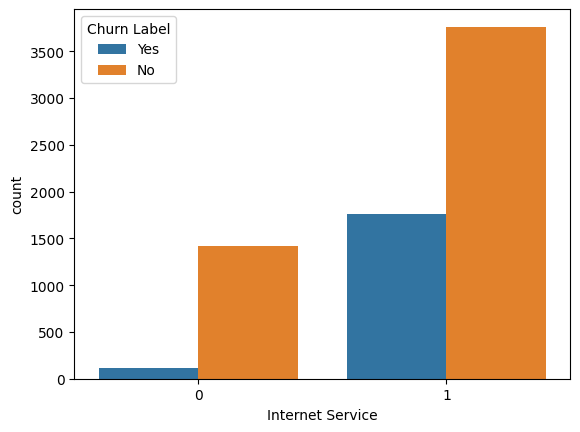

In [7]:
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)  # feature engineering
sns.countplot(data=df, x="Internet Service", hue="Churn Label")
# plt.title("Churn Label vs Internet Service")
plt.show()

## Payment Method

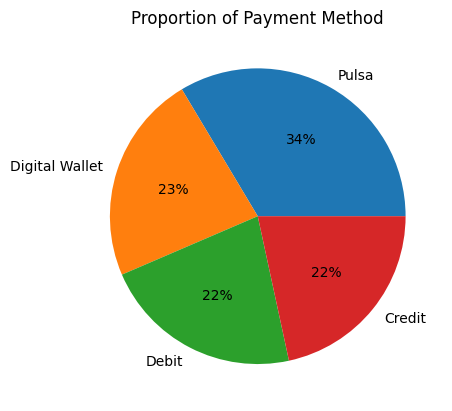

In [189]:
plot_df = df["Payment Method"].value_counts(normalize=True) * 100
plt.pie(plot_df, labels=plot_df.index, autopct="%.0f%%")
plt.title(f"Proportion of Payment Method")
plt.show()

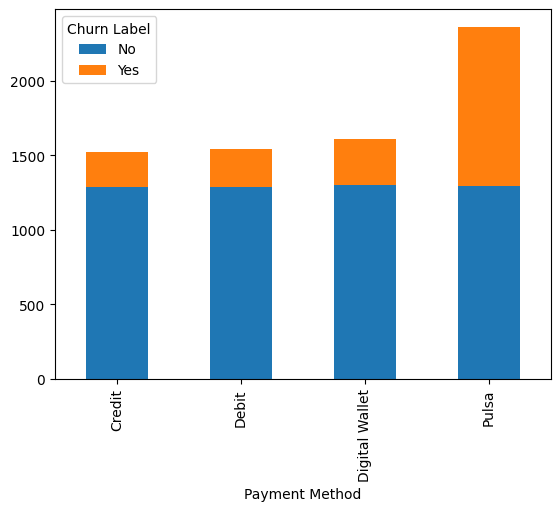

In [190]:
plot_df = df.pivot_table(index="Payment Method", columns="Churn Label", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
# plt.title("Payment Method vs Churn Label")
plt.show()

In [191]:
churn_payment_method = df.pivot_table(index="Payment Method", columns="Churn", values="Customer ID", aggfunc="count", margins=True)
churn_payment_method /= churn_payment_method.loc['All', :]
churn_payment_method = churn_payment_method.loc[churn_payment_method.index != 'All', churn_payment_method.columns != 'All']
churn_payment_method

Churn,0,1
Payment Method,,
Credit,0.249324,0.124131
Debit,0.248550,0.138042
Digital Wallet,0.252029,0.164794
Pulsa,0.250097,0.573034


1. Users buy using pulsa has high change of churn

## Tenure Months

In [192]:
df.pivot_table(index="Churn", values="Tenure Months", aggfunc="mean")

,Tenure Months
Churn,
0,37.569965
1,17.979133


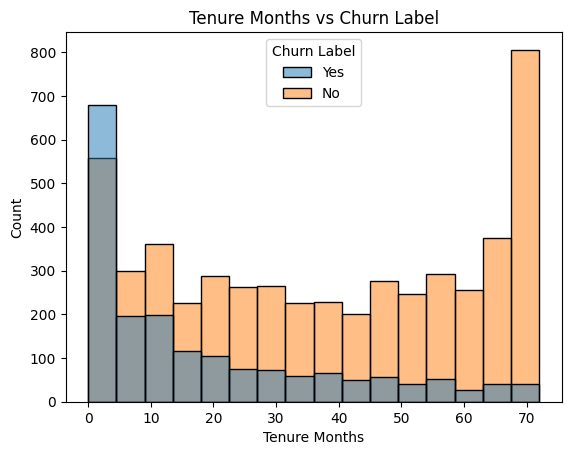

In [193]:
sns.histplot(data=df, x='Tenure Months', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

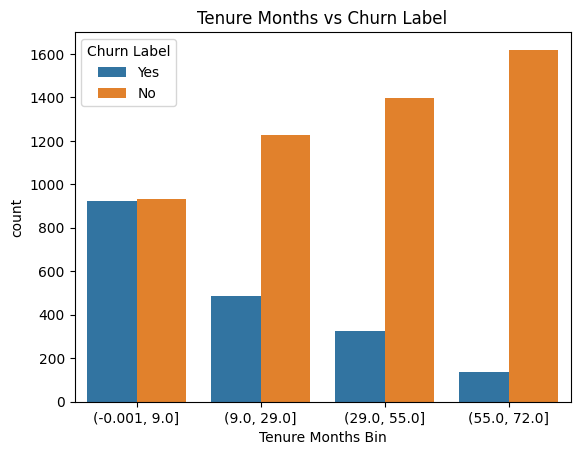

In [194]:
df["Tenure Months Bin"] = pd.qcut(df["Tenure Months"], 4)
sns.countplot(data=df, x='Tenure Months Bin', hue='Churn Label')
plt.title("Tenure Months vs Churn Label")
plt.show()

1. 0 - 9 = 1
2. 10 - 29 = 2
3. 30 - 55 = 3
4. 56 < = 4

## Monthly Purchase

In [195]:
df.pivot_table(index="Churn", values="Monthly Purchase (Thou. IDR)", aggfunc="mean")

,Monthly Purchase (Thou. IDR)
Churn,
0,79.644661
1,96.773732


Users churn because of monthly payment that they have to spend is more than the un-churned. But does it make sense. Let's take a look at the distribution

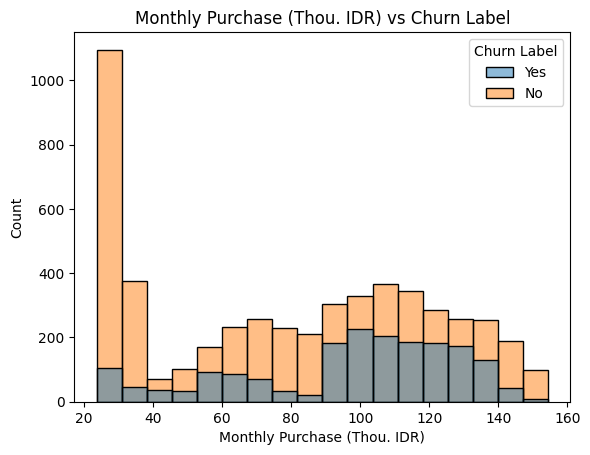

In [196]:
sns.histplot(data=df, x="Monthly Purchase (Thou. IDR)", hue="Churn Label")
plt.title("Monthly Purchase (Thou. IDR) vs Churn Label")
plt.show()

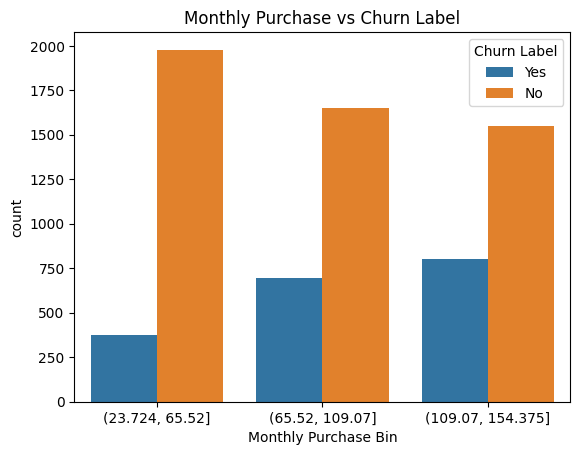

In [197]:
df["Monthly Purchase Bin"] = pd.qcut(df["Monthly Purchase (Thou. IDR)"], 3)
sns.countplot(data=df, x='Monthly Purchase Bin', hue='Churn Label')
plt.title("Monthly Purchase vs Churn Label")
plt.show()

Customer also churned for low monhtly purchases, but mose of the churned users spend between Rp 100,000.00 - Rp 120,000.00 a month.

1. < 20 = 1
2. < 66 = 2
3. < 110 = 3
4. < 160 = 4

## CLTV

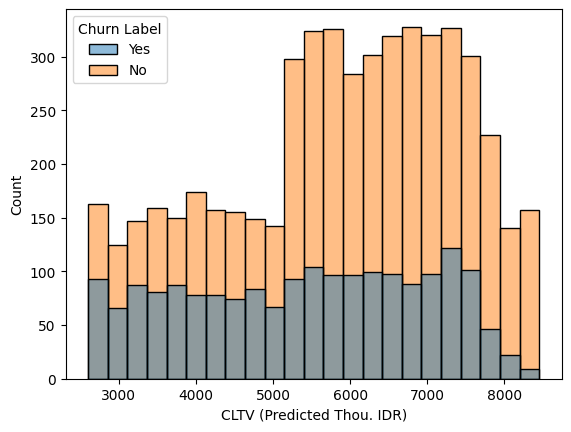

In [198]:
sns.histplot(data=df, x='CLTV (Predicted Thou. IDR)', hue='Churn Label')
plt.show()
plt.show()

CLTV can't be used as a feature because CLTV are normally distributed for all churned users, hence it is not a strong feature. The CLTV above Rp 7,500,000 has a high chance of churning.

## Call Center
Check whether the customer uses the call center service

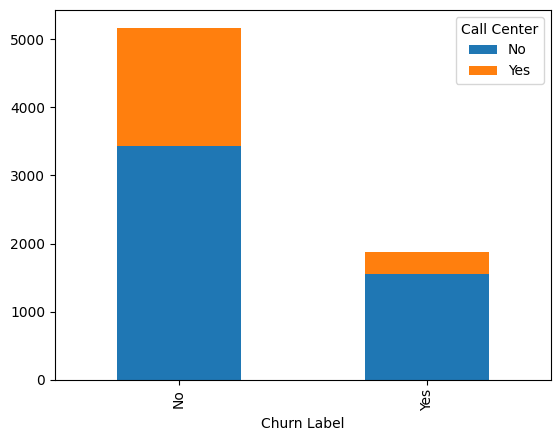

In [199]:
plot_df = df.pivot_table(index="Churn Label", columns="Call Center", values="Customer ID", aggfunc="count")
plot_df.plot(kind="bar", stacked=True)
# plt.title("Payment Method vs Churn Label")
plt.show()

## Total Purchase

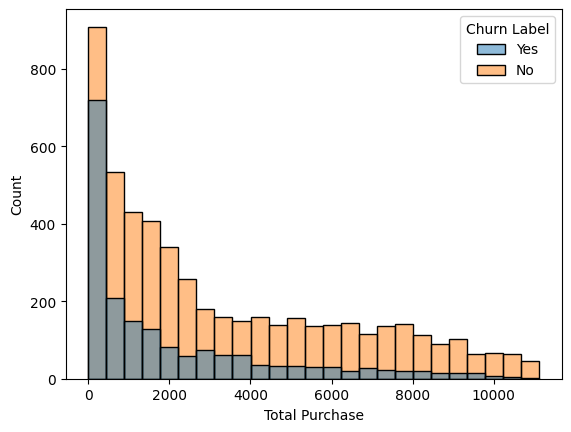

In [200]:
sns.histplot(data=df, x="Total Purchase", hue="Churn Label")
# plt.title("Total Purchase vs Churn Label")
plt.show()

Really hard to tell based on the Total 

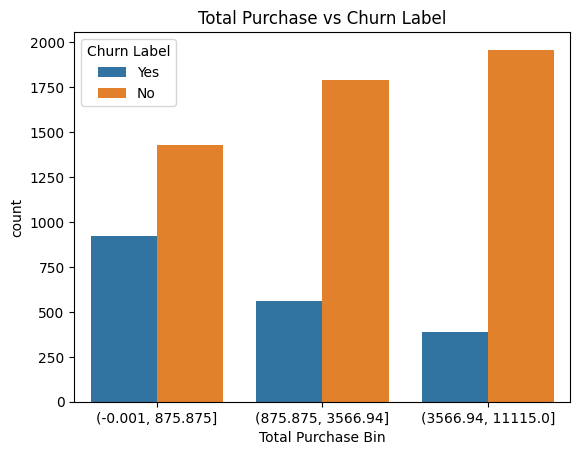

In [201]:
df["Total Purchase Bin"] = pd.qcut(df["Total Purchase"], 3)
sns.countplot(data=df, x='Total Purchase Bin', hue='Churn Label')
plt.title("Total Purchase vs Churn Label")
plt.show()

## Used Products

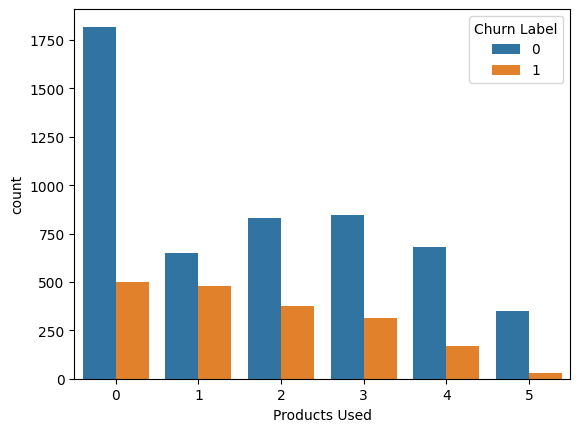

In [233]:
def uses_internet_for_product(data):
    if data == "Yes": 
        return 1
    return 0

# Total Product Used
df["Products Used"] = df[['Games Product', 'Music Product', 'Education Product', 'Video Product', 'Use MyApp']]\
    .apply(lambda x: uses_internet_for_product(x['Games Product'])
        + uses_internet_for_product(x['Music Product'])
        + uses_internet_for_product(x['Education Product'])
        + uses_internet_for_product(x['Video Product'])
        + uses_internet_for_product(x['Use MyApp']), axis=1)

sns.countplot(data=df, x="Products Used", hue="Churn Label")
# plt.title("Products Used vs Churn")
plt.show()

In [235]:
pd.qcut(df["Products Used"], 3)

0          (1.0, 3.0]
1       (-0.001, 1.0]
2          (1.0, 3.0]
3          (1.0, 3.0]
4          (3.0, 5.0]
            ...      
7038    (-0.001, 1.0]
7039       (3.0, 5.0]
7040       (3.0, 5.0]
7041    (-0.001, 1.0]
7042       (3.0, 5.0]
Name: Products Used, Length: 7043, dtype: category
Categories (3, interval[float64, right]): [(-0.001, 1.0] < (1.0, 3.0] < (3.0, 5.0]]

<Axes: xlabel='Products Used Bin', ylabel='count'>

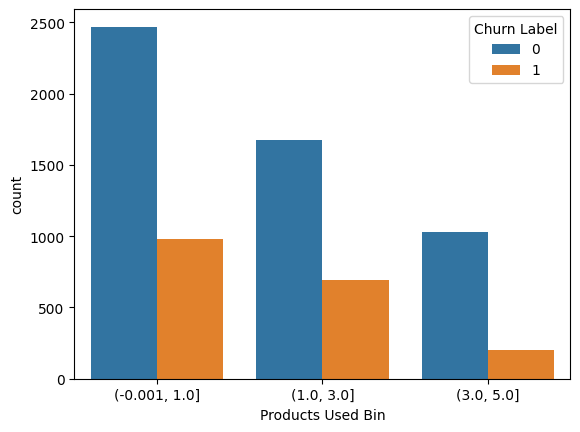

In [239]:
df["Products Used Bin"] = pd.qcut(df["Products Used"], 3)
sns.countplot(data=df, x="Products Used Bin", hue="Churn Label")

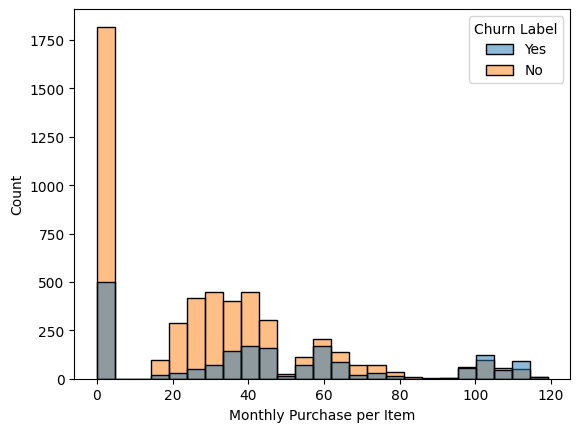

In [204]:
df["Monthly Purchase per Item"] = df["Monthly Purchase (Thou. IDR)"] / (df["Products Used"])
df["Monthly Purchase per Item"] = df["Monthly Purchase per Item"].replace(np.inf, 0)

sns.histplot(data=df, x="Monthly Purchase per Item", hue="Churn Label")
# plt.title("Monthly Purchase per Item vs Churn")
plt.show()

In [205]:
df["Monthly Purchase per Item"].replace(np.inf, 0)

0       35.002500
1        0.000000
2       43.181667
3       45.413333
4       33.702500
          ...    
7038     0.000000
7039    27.560000
7040    33.540000
7041    38.480000
7042    34.336250
Name: Monthly Purchase per Item, Length: 7043, dtype: float64

User that pay more and use little of the product services has a high chance of churning

## Correlation Map 

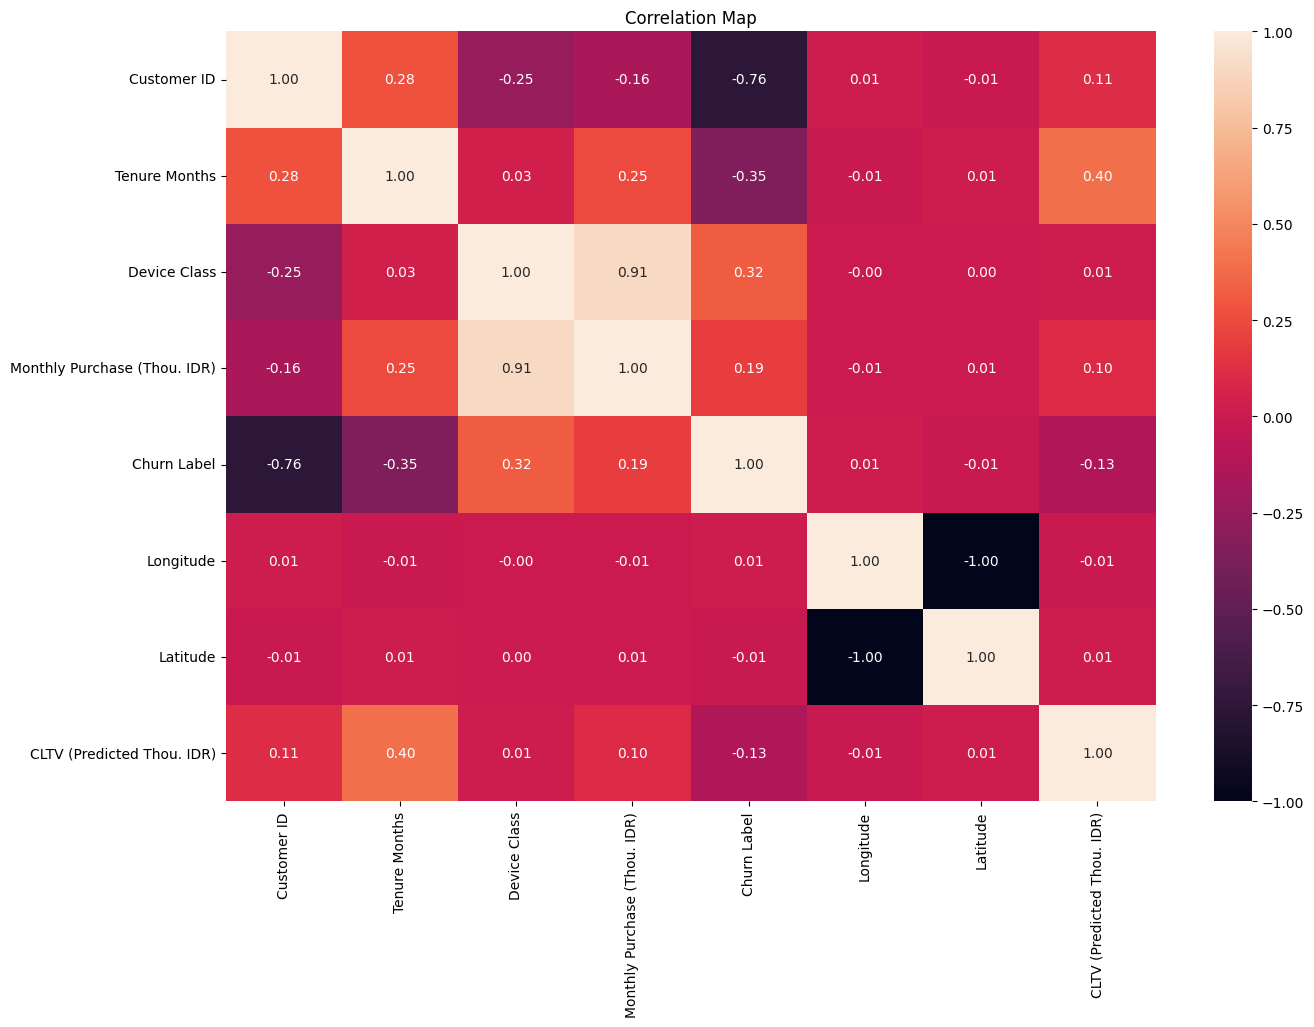

In [159]:
device_class_map = {
    "High End": 3,
    "Mid End": 2,
    "Low End": 1
}
df["Device Class"] = df["Device Class"].replace(device_class_map)
corr = df.select_dtypes([int, float]).corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Correlation Map")
plt.show()

# Modelling

In [9]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# imports
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, roc_curve, accuracy_score
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

# machine learning model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, 
    RandomForestClassifier,
    ExtraTreesClassifier,
    GradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (recall_score, precision_score, f1_score, roc_auc_score)
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit, cross_val_score, KFold)
from sklearn.preprocessing import StandardScaler
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


# oversampling
from imblearn.over_sampling import (
    SMOTE, 
    SMOTENC,
    SVMSMOTE
)

# hyperparameter tuning
import optuna

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def evaluate(model, y_true, y_pred, y_pred_proba):
    """
        Evaluate model performance
    """
    print(f"""
    METRICS
    Accuracy: {accuracy_score(y_true, y_pred)}
    Precision: {precision_score(y_true, y_pred)}
    Recall: {recall_score(y_true, y_pred)}
    F1 Score: {f1_score(y_true, y_pred)}
    ROC AUC score: {roc_auc_score(y_true, y_pred)}
    Specificity: {specificity_score(y_true, y_pred)}
    """)

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=model.classes_)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    display.plot()
    plt.title(f"Confusion Matrix of {model.__class__.__name__}")
    plt.show()

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_true,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr)
    plt.plot((0, 1), (0, 1))
    plt.title("ROC Curve")
    plt.show()

## Baseline Model
Select a simple logstic regression to get the feel about the base performance.

[0.83867319 0.85176635 0.82193059 0.8422055  0.84148652] 
Score Mean: 0.8392124311311455

    METRICS
    Accuracy: 0.7906316536550745
    Precision: 0.6321070234113713
    Recall: 0.5053475935828877
    F1 Score: 0.5616641901931649
    ROC AUC score: 0.6995337001730864
    Specificity: 0.893719806763285
    


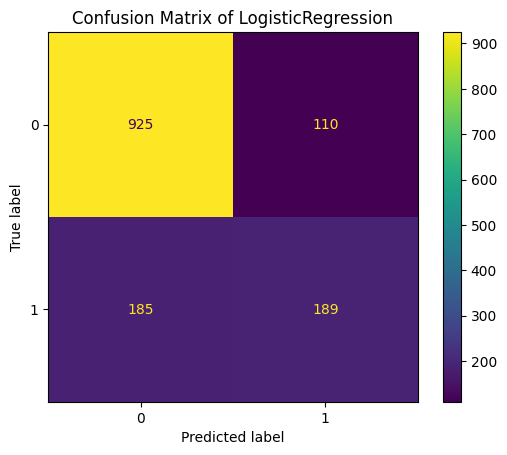

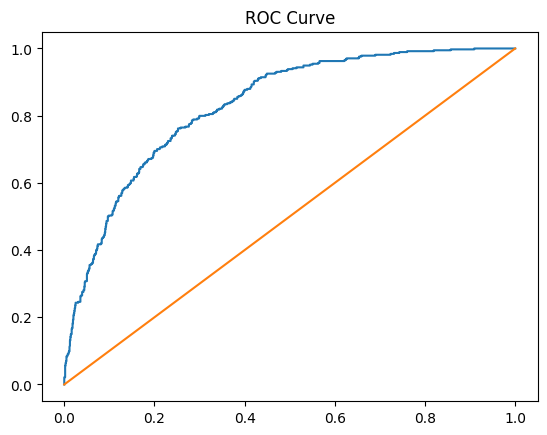

In [11]:
# Data Preparation
# ==============================================
df = df_ori.copy()

# Encoding
# ==============================================
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})  # encode Device Class  
df['Churn Label'] = df['Churn Label'].replace({"Yes": 1, "No": 0})  # encode Churn Label

# Feature Selection
# ==============================================df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data

# Data Splitting
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scaling
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Perfrom CV
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
print(score, f"\nScore Mean: {score.mean()}")

# Train Logistic Regression
# ==============================================
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train, y_train)

# Predict using Logistic Regression
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

## Model Improvement

### Feature Engineering

LogisticRegression
ROC AUC Scores: 0.85329307568438,0.8821014492753623,0.839645732689211,0.7941384863123995,0.8702737520128824
ROC AUC Mean: 0.847890499194847


    METRICS
    Accuracy: 0.794889992902768
    Precision: 0.6402640264026402
    Recall: 0.5187165775401069
    F1 Score: 0.5731166912850812
    ROC AUC score: 0.7067012839391356
    Specificity: 0.8946859903381642
    


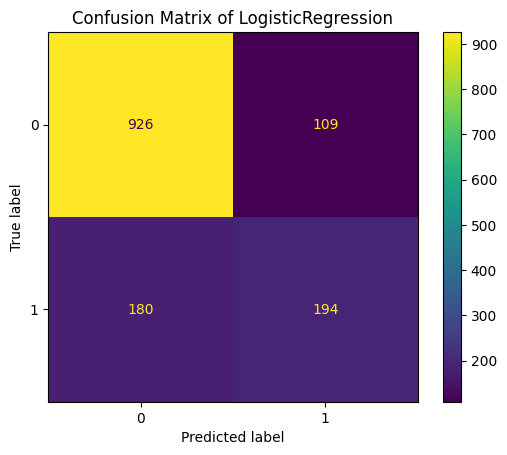

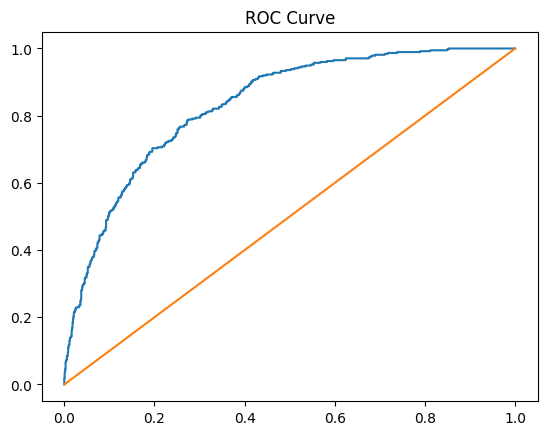

In [276]:
# Data Preparation
# ==============================================
df = df_ori.copy()

# Feature engineering
# ==============================================
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

# Encoding
# ==============================================
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})

# Feature Selection
# ==============================================
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]

# Data Splitting
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Scale data
# ==============================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42)
cv = StratifiedShuffleSplit(n_splits=5, random_state=42)
roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")
print(f"""{model.__class__.__name__}
ROC AUC Scores: {','.join(roc_auc.astype(str))}
ROC AUC Mean: {roc_auc.mean()}
""")

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

### Perform Oversampling
Oversampling is used to tackle imbalance class problem.

SVMSMOTE

SMOTE, LogisticRegression
ROC AUC Scores: 0.9285660108753996,0.9313388293775817,0.9231129956358375,0.9344092044155057,0.9257465168381993
ROC AUC Mean: 0.9286347114285046


    METRICS
    Accuracy: 0.794889992902768
    Precision: 0.6197183098591549
    Recall: 0.5882352941176471
    F1 Score: 0.6035665294924554
    ROC AUC score: 0.7289002557544757
    Specificity: 0.8695652173913043
    


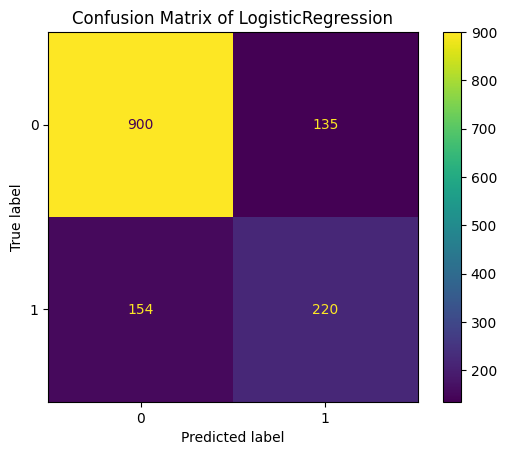

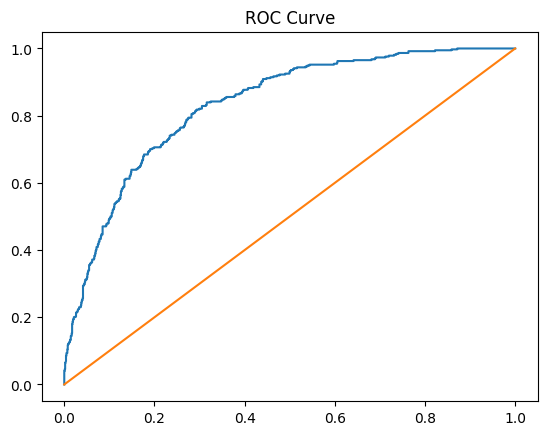

In [15]:
# Data Preparation
# ==============================================
df = df_ori.copy()

# Feature Engineering
# ========================================
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

# Encoding
# ========================================
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})

# Feature Selection
# ========================================
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]

# Data Splitting
# ========================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling
# ========================================
oversampler = SMOTE(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Cross Validation
# ========================================
model = LogisticRegression(random_state=42, max_iter=200)
cv = StratifiedShuffleSplit(n_splits=5,  test_size=0.2, random_state=42)
roc_auc = cross_val_score(model, X_train, y_train, cv=cv, scoring="roc_auc")

# Document The Result
# ========================================
print(f"""{oversampler.__class__.__name__}, {model.__class__.__name__}
ROC AUC Scores: {','.join(roc_auc.astype(str))}
ROC AUC Mean: {roc_auc.mean()}
""")

# Train Dummy Classifier
# ==============================================
model = LogisticRegression(random_state=42, max_iter=200)
model.fit(X_train, y_train)

# Predict using Dummy Classifier
# ==============================================
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Evaluate Model
# ==============================================
evaluate(model, y_test, y_pred, y_pred_proba)

Using oversampling we increase the the performance of the model based on ROC AUC. 

Note:

We have both categorical and continuous. SMOTENC is designed for that sepcific use case, but we limit the scope to SVMSMOTE only.

### Try Other Models

LogisticRegression done
DecisionTreeClassifier done
RandomForestClassifier done
AdaBoostClassifier done
GradientBoostingClassifier done
XGBClassifier done
Learning rate set to 0.024285
0:	learn: 0.6760450	total: 15.2ms	remaining: 15.2s
1:	learn: 0.6640463	total: 25.2ms	remaining: 12.6s
2:	learn: 0.6491031	total: 31.6ms	remaining: 10.5s
3:	learn: 0.6353919	total: 38.6ms	remaining: 9.61s
4:	learn: 0.6249716	total: 43.5ms	remaining: 8.66s
5:	learn: 0.6155572	total: 47.5ms	remaining: 7.86s
6:	learn: 0.6040924	total: 53ms	remaining: 7.52s
7:	learn: 0.5959525	total: 57ms	remaining: 7.06s
8:	learn: 0.5874845	total: 61ms	remaining: 6.72s
9:	learn: 0.5752542	total: 64.9ms	remaining: 6.43s
10:	learn: 0.5646403	total: 70.9ms	remaining: 6.38s
11:	learn: 0.5508579	total: 74.6ms	remaining: 6.14s
12:	learn: 0.5423491	total: 80.2ms	remaining: 6.09s
13:	learn: 0.5341383	total: 85.7ms	remaining: 6.04s
14:	learn: 0.5265611	total: 90.6ms	remaining: 5.95s
15:	learn: 0.5209554	total: 94.1ms	remaining: 5.79s

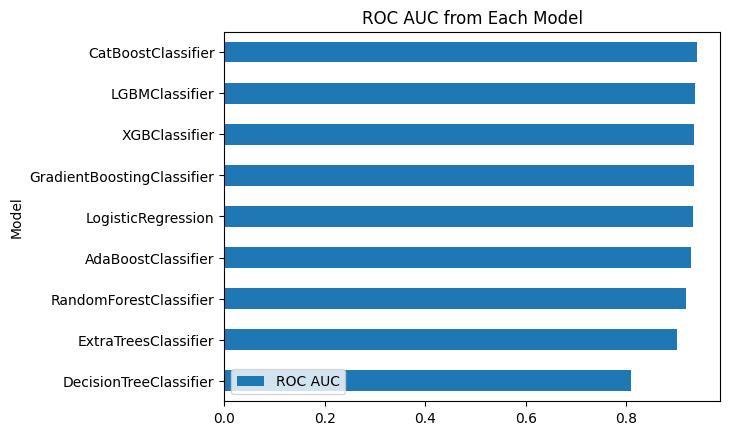

,ROC AUC
Model,
DecisionTreeClassifier,0.809402
ExtraTreesClassifier,0.899975
RandomForestClassifier,0.918258
AdaBoostClassifier,0.929282
LogisticRegression,0.933280
GradientBoostingClassifier,0.933533
XGBClassifier,0.933553
LGBMClassifier,0.937158
CatBoostClassifier,0.939501


In [16]:
# Data Preparation
# ==============================================
df = df_ori.copy()
# feature engineering
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

# encoding
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})

# drop unimportant data
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

# Oversampling
# ========================================
oversampler = SMOTE(random_state=42)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

# Scale data
# ========================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)

# Load Models
# ========================================
models = [
    LogisticRegression(random_state=42, max_iter=200),
    DecisionTreeClassifier(random_state=42), 
    RandomForestClassifier(random_state=42), 
    AdaBoostClassifier(random_state=42), 
    GradientBoostingClassifier(random_state=42), 
    xgb.XGBClassifier(random_state=42),
    cb.CatBoostClassifier(random_state=42), 
    lgb.LGBMClassifier(objective='binary', random_state=42), 
    ExtraTreesClassifier(random_state=42)
]

recalls = []
precisions = []
f1s = []
roc_aucs = []

for model in models:    
    # Cross Validation
    # ========================================
    cv = StratifiedShuffleSplit(n_splits=5, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    roc_aucs.append(score.mean())
    print(f"{model.__class__.__name__} done")

df_model = pd.DataFrame(
    {
        "Model": [model.__class__.__name__ for model in models],
        "ROC AUC": roc_aucs,
    }
).set_index("Model").sort_values(by="ROC AUC")

# plot the f1 score comparison
df_model.plot.barh()
plt.title("ROC AUC from Each Model")
plt.legend(loc="lower left")
plt.show()
display(df_model)

Perform Hyperparameter Tuning on Top 5 Best models
1. GradientBoostingClassifier
2. LogisticRegression
3. XGBClassifier
4. LGBMClassifier
5. CatBoostClassifier

# Hyperparameter Tuning

In [ ]:
df = df_ori.copy()
df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
df["Products Used"] = df[["Games Product", "Music Product", "Education Product", "Video Product", "Use MyApp"]]\
    .apply(lambda x: uses_internet_for_product(x["Games Product"])
        + uses_internet_for_product(x["Music Product"])
        + uses_internet_for_product(x["Education Product"])
        + uses_internet_for_product(x["Video Product"])
        + uses_internet_for_product(x["Use MyApp"]), axis=1)
df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]
df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})
df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)", "Products Used"])
X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]


In [17]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    df = data.copy()
    # feature engineering
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

    # encoding
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})

    # drop unimportant data
    df = df.drop(columns=["Customer ID", "Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING
    X_train, y_train = smote.fit_resample(X_train, y_train)  # <<<<<<<<<<<<< SMOTE OVERSAMPLING

    # Scale data
    # ==============================================
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # <<<<<<<<<<<<< SCALING
    X_val = scaler.transform(X_val)  # <<<<<<<<<<<<< SCALING
    X_test = scaler.transform(X_test)  # <<<<<<<<<<<<< SCALING

    return (X_train, X_val, X_test, y_train, y_val, y_test)

## GradientBoosting

In [18]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.0001, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, 50),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 256, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 100, 500),
    }

    # Cross validation
    # ==============================================
    model = GradientBoostingClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = GradientBoostingClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-10 10:15:39,626] A new study created in memory with name: no-name-40faba15-2ea4-49b8-8e1c-66446deb79d6
[I 2023-11-10 10:15:43,856] Trial 0 finished with value: 0.741152283299083 and parameters: {'learning_rate': 0.0006278722766693781, 'n_estimators': 300, 'subsample': 0.9094422894534515, 'min_samples_split': 150, 'min_samples_leaf': 251}. Best is trial 0 with value: 0.741152283299083.
[I 2023-11-10 10:15:47,196] Trial 1 finished with value: 0.7489859376176796 and parameters: {'learning_rate': 0.021046435296938053, 'n_estimators': 300, 'subsample': 0.6320858138431606, 'min_samples_split': 40, 'min_samples_leaf': 232}. Best is trial 1 with value: 0.7489859376176796.
[I 2023-11-10 10:15:47,841] Trial 2 finished with value: 0.7446777415548598 and parameters: {'learning_rate': 0.06949449346024308, 'n_estimators': 100, 'subsample': 0.4557455484190695, 'min_samples_split': 106, 'min_samples_leaf': 431}. Best is trial 1 with value: 0.7489859376176796.
[I 2023-11-10 10:15:51,263] Tri

Number of finished trials:  25
Best trial:
  Value: 0.7585993565949023
  Params: 
    learning_rate: 0.0017414720237900656
    n_estimators: 200
    subsample: 0.3524336766915679
    min_samples_split: 4
    min_samples_leaf: 170

Recalls: 0.741
Precision: 0.526
F1 Score: 0.615
ROC AUC SCORE: 0.750



## LogisticRegression

In [19]:
## Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        'C' : trial.suggest_float("C", 1e-6, 1, log=True),
        'max_iter': 500
    }

    # Cross validation
    # ==============================================
    model = LogisticRegression(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = LogisticRegression(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-10 10:16:35,516] A new study created in memory with name: no-name-759294a9-ed26-4a45-846a-2726fd147b04
[I 2023-11-10 10:16:35,531] Trial 0 finished with value: 0.7316365944718806 and parameters: {'C': 1.983589933112388e-05}. Best is trial 0 with value: 0.7316365944718806.
[I 2023-11-10 10:16:35,561] Trial 1 finished with value: 0.7384830846145845 and parameters: {'C': 0.05065309171490744}. Best is trial 1 with value: 0.7384830846145845.
[I 2023-11-10 10:16:35,611] Trial 2 finished with value: 0.7305678390698241 and parameters: {'C': 0.28778778052871}. Best is trial 1 with value: 0.7384830846145845.
[I 2023-11-10 10:16:35,631] Trial 3 finished with value: 0.739239820822081 and parameters: {'C': 0.0006264252393695153}. Best is trial 3 with value: 0.739239820822081.
[I 2023-11-10 10:16:35,641] Trial 4 finished with value: 0.7357529166621837 and parameters: {'C': 0.0012453522502463336}. Best is trial 3 with value: 0.739239820822081.
[I 2023-11-10 10:16:35,661] Trial 5 finished w

Number of finished trials:  25
Best trial:
  Value: 0.7456711819789189
  Params: 
    C: 0.003916732570385151

Recalls: 0.650
Precision: 0.564
F1 Score: 0.604
ROC AUC SCORE: 0.734



## Random Forest

In [291]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "max_depth": trial.suggest_int("max_depth", 3, 10, 1),
        "min_samples_split": trial.suggest_int("min_samples_split", 50, 200, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 50, 200, 50),
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, 50),
        "max_samples": trial.suggest_float("max_samples", 0.5, 0.9, step=0.1),
        "max_features": trial.suggest_int("max_features", 1, len(X.columns)),
        "bootstrap": True
    }

    # Cross validation
    # ==============================================
    model = RandomForestClassifier(**param, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = RandomForestClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-09 15:09:45,985] A new study created in memory with name: no-name-79fdd96f-84dc-4de4-bfc7-85f09c124dd8
[I 2023-11-09 15:09:49,999] Trial 0 finished with value: 0.7487330944772603 and parameters: {'max_depth': 8, 'min_samples_split': 50, 'min_samples_leaf': 200, 'n_estimators': 500, 'max_samples': 0.6, 'max_features': 26}. Best is trial 0 with value: 0.7487330944772603.
[I 2023-11-09 15:09:53,369] Trial 1 finished with value: 0.7520281247646408 and parameters: {'max_depth': 7, 'min_samples_split': 150, 'min_samples_leaf': 100, 'n_estimators': 450, 'max_samples': 0.5, 'max_features': 21}. Best is trial 1 with value: 0.7520281247646408.
[I 2023-11-09 15:09:57,891] Trial 2 finished with value: 0.754307299455939 and parameters: {'max_depth': 10, 'min_samples_split': 100, 'min_samples_leaf': 200, 'n_estimators': 900, 'max_samples': 0.5, 'max_features': 17}. Best is trial 2 with value: 0.754307299455939.
[I 2023-11-09 15:09:58,865] Trial 3 finished with value: 0.7529794246652967 an

Number of finished trials:  25
Best trial:
  Value: 0.762170541801606
  Params: 
    max_depth: 5
    min_samples_split: 150
    min_samples_leaf: 50
    n_estimators: 800
    max_samples: 0.8
    max_features: 10

Recalls: 0.741
Precision: 0.537
F1 Score: 0.622
ROC AUC SCORE: 0.755



## CatBoostClassifier

In [20]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)


# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 3, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    # Cross validation
    # ==============================================
    model = cb.CatBoostClassifier(**param, random_state=42)
    model.fit(X_train, y_train, verbose=0)
    preds = model.predict(X_val)
    y_pred = np.rint(preds)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


# Train using best parameters
# ==============================================
model = cb.CatBoostClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train, verbose=0)


# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-10 10:16:36,516] A new study created in memory with name: no-name-7b42a420-fefc-4013-86da-37ee6c630de6
[I 2023-11-10 10:16:42,166] Trial 0 finished with value: 0.7439183155267207 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.011804033747662052, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 7.89894068288879}. Best is trial 0 with value: 0.7439183155267207.
[I 2023-11-10 10:16:48,951] Trial 1 finished with value: 0.7314249952479835 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.05550819197956904, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8069892194239976}. Best is trial 0 with value: 0.7439183155267207.
[I 2023-11-10 10:17:03,188] Trial 2 finished with value: 0.7286491003446556 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.08978719712397003, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.37435776

Number of finished trials:  25
Best trial:
  Value: 0.7450058996732765
  Params: 
    objective: Logloss
    colsample_bylevel: 0.01308758831342242
    depth: 4
    boosting_type: Ordered
    bootstrap_type: Bayesian
    bagging_temperature: 5.673667392836825

Recalls: 0.743
Precision: 0.499
F1 Score: 0.597
ROC AUC SCORE: 0.737



## XGBClassifier

In [21]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)

# Transform data into DMatrix
# ==============================================
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Hyperparameter Tuning
# ==============================================
def objective(trial):

    # Hyperparameters
    # ==============================================
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        param["max_depth"] = trial.suggest_int("max_depth", 3, 10, step=1)
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    return roc_auc_score(y_val, pred_labels)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = xgb.XGBClassifier(**study.best_params, random_state=42)
model.fit(X_train, y_train)

# Predict
# ==============================================
preds = model.predict(X_test)
y_pred = np.rint(preds)
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")

[I 2023-11-10 10:19:06,501] A new study created in memory with name: no-name-42e5291c-2e0d-4656-aa9b-72f97d09caeb
[I 2023-11-10 10:19:06,561] Trial 0 finished with value: 0.7419215720029121 and parameters: {'booster': 'gblinear', 'lambda': 0.45300399192819774, 'alpha': 1.1246285684721548e-08, 'subsample': 0.5916299014078947, 'colsample_bytree': 0.24618056119357137}. Best is trial 0 with value: 0.7419215720029121.
[I 2023-11-10 10:19:06,575] Trial 1 finished with value: 0.7422622826176617 and parameters: {'booster': 'gblinear', 'lambda': 0.059766894254580274, 'alpha': 0.00035537949233188675, 'subsample': 0.9551020893326063, 'colsample_bytree': 0.8007809920400664}. Best is trial 1 with value: 0.7422622826176617.
[I 2023-11-10 10:19:06,596] Trial 2 finished with value: 0.7524925671289572 and parameters: {'booster': 'dart', 'lambda': 0.0003013895201668004, 'alpha': 8.549440730230902e-08, 'subsample': 0.3783802580187831, 'colsample_bytree': 0.8580477003306586, 'max_depth': 3, 'min_child_wei

Number of finished trials:  25
Best trial:
  Value: 0.7572553428804034
  Params: 
    booster: gbtree
    lambda: 3.5357199281629924e-07
    alpha: 1.4745946794841902e-06
    subsample: 0.31662364813510124
    colsample_bytree: 0.9988097385706228
    max_depth: 3
    min_child_weight: 8
    eta: 0.006167849575019472
    gamma: 0.004457430543613668
    grow_policy: depthwise

Recalls: 0.778
Precision: 0.513
F1 Score: 0.618
ROC AUC SCORE: 0.756



## LGBMClassifier

In [22]:
# Data Preparation
# ==============================================
(X_train, X_val, X_test, y_train, y_val, y_test) = data_preparation(df_ori)

# Hyperparameter Tuning
# ==============================================
def objective(trial):
    # Hyperparameters
    # ==============================================
    dtrain = lgb.Dataset(X_train, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 50, 200, 50),
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_val)
    y_pred = np.rint(preds)
    return roc_auc_score(y_val, y_pred)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Train using best parameters
# ==============================================
model = lgb.LGBMClassifier(**study.best_params, verbose=0, random_state=42)    
model.fit(X_train, y_train)

# Predict
# ==============================================
y_pred_proba = model.predict_proba(X_test)
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:, 1]]
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


[I 2023-11-10 10:19:07,872] A new study created in memory with name: no-name-1ed26a0d-45a8-4caf-aed5-3d10747d7c6b
[I 2023-11-10 10:19:08,040] Trial 0 finished with value: 0.6914560537103387 and parameters: {'lambda_l1': 0.09465096084134193, 'lambda_l2': 0.0001544617419215193, 'num_leaves': 192, 'feature_fraction': 0.7415163600179855, 'bagging_fraction': 0.6164027352781078, 'bagging_freq': 7, 'min_child_samples': 50}. Best is trial 0 with value: 0.6914560537103387.
[I 2023-11-10 10:19:08,120] Trial 1 finished with value: 0.7113804518181396 and parameters: {'lambda_l1': 2.8105610057404936e-07, 'lambda_l2': 1.449576563066298e-06, 'num_leaves': 179, 'feature_fraction': 0.850719716207121, 'bagging_fraction': 0.8409582276271781, 'bagging_freq': 7, 'min_child_samples': 150}. Best is trial 1 with value: 0.7113804518181396.
[I 2023-11-10 10:19:08,195] Trial 2 finished with value: 0.7242207589597924 and parameters: {'lambda_l1': 3.2922711972236523e-07, 'lambda_l2': 2.483081898073167e-05, 'num_le

Number of finished trials:  25
Best trial:
  Value: 0.7535442870002762
  Params: 
    lambda_l1: 0.0008760097739004018
    lambda_l2: 0.3476902177667727
    num_leaves: 3
    feature_fraction: 0.6399218735601468
    bagging_fraction: 0.5596132124188054
    bagging_freq: 5
    min_child_samples: 100
[LightGBM] [Warning] feature_fraction is set=0.6399218735601468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399218735601468
[LightGBM] [Warning] lambda_l1 is set=0.0008760097739004018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008760097739004018
[LightGBM] [Warning] lambda_l2 is set=0.3476902177667727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3476902177667727
[LightGBM] [Warning] bagging_fraction is set=0.5596132124188054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5596132124188054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warnin

## Summarize
| No. | Model               | Recall | Precision | F1    | ROC AUC |
|-----|---------------------|--------|-----------|-------|---------|
| 1.  | GradientBoost       | 0.741  | 0.526     | 0.615 | 0.750   |
| 2.  | Logistic Regression | 0.650  | 0.564     | 0.604 | 0.734   |
| 3.  | CatBoost            | 0.743  | 0.499     | 0.507 | 0.737   |
| 4.  | XGBoost             | 0.778  | 0.513     | 0.618 | 0.756   |
| 5.  | LGBM                | 0.690  | 0.550     | 0.612 | 0.743   |

Base on these model we want to be able to detect as many as churn users as possible, sacrificing a little bit of precision is okay. Predicting unchurned users as churn users doesn't bother use because they will be happy **(low chance of churning)** if we give approach with some retention strategy such as promotion, discount, etc.

# Inspect Models

In [34]:
def data_preparation(data):
    # Data Preparation
    # ==============================================
    
    df = data.copy()
    # feature engineering
    df["Internet Service"] = df.apply(lambda x: check_internet_service(x), axis=1)
    df["Total Purchase"] = df["Tenure Months"] * df["Monthly Purchase (Thou. IDR)"]

    # encoding
    df["Device Class"] = df["Device Class"].replace({"High End": 3, "Mid End": 2, "Low End": 1})
    df["Churn Label"] = df["Churn Label"].replace({"Yes": 1, "No": 0})
    
    df = df.drop(columns=["Location", "Longitude", "Latitude", "CLTV (Predicted Thou. IDR)"])  # drop unimportant data
    X, y = pd.get_dummies(df.drop(columns=["Churn Label"]), dtype=int), df["Churn Label"]  # split data
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)
    X_test[["Customer ID"]].to_csv("../data/processed/test_data_id.csv", index=False)
    X_train = X_train.drop(columns=["Customer ID"])
    X_test = X_test.drop(columns=["Customer ID"])

    # Oversampling for balancing dataset
    # ==============================================
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Scale data (tree model don't need for scaling)
    # ==============================================
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)  # <<<<<<<<<<<<< SCALING
    X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)  # <<<<<<<<<<<<< SCALING
    
    return X_train, X_test, y_train, y_test

In [27]:
pair_model_params = [
    (GradientBoostingClassifier,{
        "learning_rate": 0.0017414720237900656,
        "n_estimators": 200,
        "subsample": 0.3524336766915679,
        "min_samples_split": 4,
        "min_samples_leaf": 170,
        "random_state": 42

    }),
    (LogisticRegression,{
        "C": 0.003916732570385151,
        "random_state": 42

    }),
    (cb.CatBoostClassifier, {
        "objective": "Logloss",
        "colsample_bylevel": 0.01308758831342242,
        "depth": 4,
        "boosting_type": "Ordered",
        "bootstrap_type": "Bayesian",
        "bagging_temperature": 5.673667392836825,
        "random_state": 42
    }),
    (xgb.XGBClassifier, {
        "booster": "gbtree",
        "lambda": 3.5357199281629924e-07,
        "alpha": 1.4745946794841902e-06,
        "subsample": 0.31662364813510124,
        "colsample_bytree": 0.9988097385706228,
        "max_depth": 3,
        "min_child_weight": 8,
        "eta": 0.006167849575019472,
        "gamma": 0.004457430543613668,
        "grow_policy": "depthwise",
        "random_state": 42
    }),
    (lgb.LGBMClassifier, {
        "lambda_l1": 0.0008760097739004018,
        "lambda_l2": 0.3476902177667727,
        "num_leaves": 3,
        "feature_fraction": 0.6399218735601468,
        "bagging_fraction": 0.5596132124188054,
        "bagging_freq": 5,
        "min_child_samples": 100,
        "random_state": 42
    })
]

Learning rate set to 0.025403
0:	learn: 0.6931472	total: 7.53ms	remaining: 7.53s
1:	learn: 0.6931472	total: 13.7ms	remaining: 6.81s
2:	learn: 0.6931472	total: 18.9ms	remaining: 6.28s
3:	learn: 0.6931383	total: 26ms	remaining: 6.47s
4:	learn: 0.6931383	total: 31.4ms	remaining: 6.25s
5:	learn: 0.6931383	total: 37.5ms	remaining: 6.21s
6:	learn: 0.6903786	total: 45.8ms	remaining: 6.5s
7:	learn: 0.6903786	total: 52ms	remaining: 6.45s
8:	learn: 0.6878692	total: 61.4ms	remaining: 6.76s
9:	learn: 0.6875480	total: 67.3ms	remaining: 6.67s
10:	learn: 0.6875480	total: 74.7ms	remaining: 6.71s
11:	learn: 0.6875479	total: 80ms	remaining: 6.59s
12:	learn: 0.6875479	total: 85.4ms	remaining: 6.49s
13:	learn: 0.6875479	total: 93ms	remaining: 6.55s
14:	learn: 0.6875479	total: 98.8ms	remaining: 6.49s
15:	learn: 0.6875479	total: 105ms	remaining: 6.47s
16:	learn: 0.6875479	total: 111ms	remaining: 6.41s
17:	learn: 0.6875479	total: 116ms	remaining: 6.33s
18:	learn: 0.6856667	total: 124ms	remaining: 6.39s
19:	l

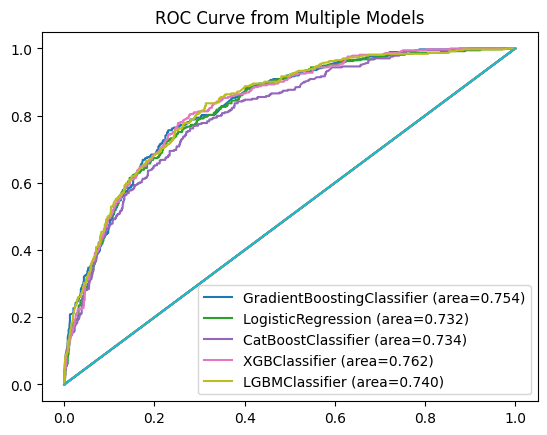

In [28]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)
threshold = 0.5

for i, (model, params) in enumerate(pair_model_params):
    # Create Model and Predict
    # ============================================== 
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]

    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba[:, -1])
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (area={roc_auc_score(y_test, y_pred):.3f})")
    plt.plot((0, 1), (0, 1))
plt.legend()
plt.title("ROC Curve from Multiple Models")
plt.show()

Learning rate set to 0.025403
0:	learn: 0.6931472	total: 6.91ms	remaining: 6.9s
1:	learn: 0.6931472	total: 12.5ms	remaining: 6.26s
2:	learn: 0.6931472	total: 17.8ms	remaining: 5.92s
3:	learn: 0.6931383	total: 25.4ms	remaining: 6.32s
4:	learn: 0.6931383	total: 30.7ms	remaining: 6.12s
5:	learn: 0.6931383	total: 38.6ms	remaining: 6.39s
6:	learn: 0.6903786	total: 47.4ms	remaining: 6.72s
7:	learn: 0.6903786	total: 55.3ms	remaining: 6.86s
8:	learn: 0.6878692	total: 61.7ms	remaining: 6.79s
9:	learn: 0.6875480	total: 69.4ms	remaining: 6.87s
10:	learn: 0.6875480	total: 75ms	remaining: 6.74s
11:	learn: 0.6875479	total: 80.3ms	remaining: 6.61s
12:	learn: 0.6875479	total: 87.8ms	remaining: 6.67s
13:	learn: 0.6875479	total: 93.5ms	remaining: 6.58s
14:	learn: 0.6875479	total: 99.1ms	remaining: 6.5s
15:	learn: 0.6875479	total: 105ms	remaining: 6.48s
16:	learn: 0.6875479	total: 111ms	remaining: 6.42s
17:	learn: 0.6875479	total: 118ms	remaining: 6.46s
18:	learn: 0.6856667	total: 124ms	remaining: 6.42s


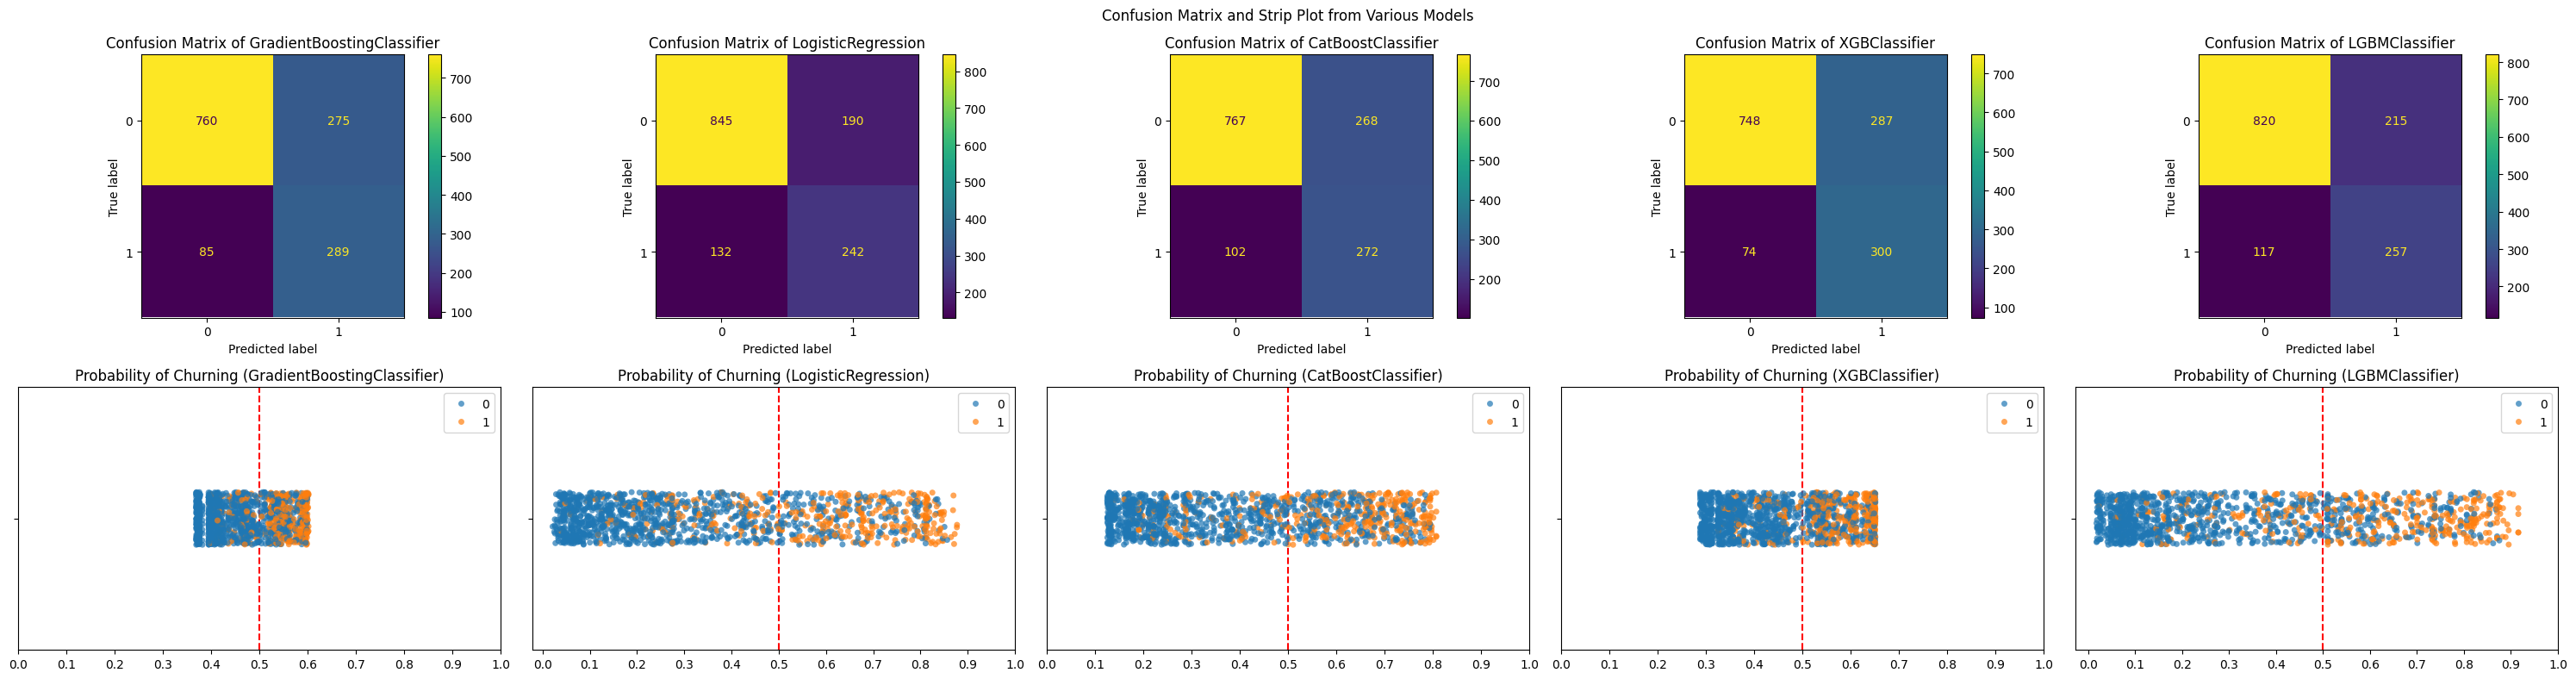

In [29]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)
threshold = 0.5

recalls = []
precisions = []
f1s = []
roc_aucs = []
models = []
fig, ax = plt.subplots(ncols=len(pair_model_params), nrows=2, figsize=(30, 8))
for i, (model, params) in enumerate(pair_model_params):
    # Create Model and Predict
    # ============================================== 
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]

    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))
    roc_aucs.append(roc_auc_score(y_test, y_pred))
    models.append(model.__class__.__name__)

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    cmp.plot(ax=ax[0][i])
    ax[0][i].set_title(f"Confusion Matrix of {model.__class__.__name__}")

    # Stripplot plot
    sns.stripplot(x=y_pred_proba[:, 1], hue=y_test.tolist(), ax=ax[1][i], alpha=0.7)
    ax[1][i].set_title(f"Probability of Churning ({model.__class__.__name__})")
    ax[1][i].axvline(threshold, label="Threshold", color="red", linestyle="--")
    ax[1][i].set_xticks(np.arange(0, 1.001, 0.1))

fig.suptitle("Confusion Matrix and Strip Plot from Various Models")
fig.tight_layout()

In [31]:
pd.DataFrame({
    "Model": models,
    "Recall": recalls,
    "Precision": precisions,
    "F1 Score": f1s,
    "ROC AUC": roc_aucs,
}).sort_values(by="ROC AUC", ascending=False).reset_index(drop=True)

,Model,Recall,Precision,F1 Score,ROC AUC
0,XGBClassifier,0.802139,0.511073,0.624350,0.762422
1,GradientBoostingClassifier,0.772727,0.512411,0.616205,0.753513
2,LGBMClassifier,0.687166,0.544492,0.607565,0.739718
3,CatBoostClassifier,0.727273,0.503704,0.595186,0.734168
4,LogisticRegression,0.647059,0.560185,0.600496,0.731742


ROC AUC score can be misleading, which are proven in the previous plot. LGBM overall is all Around Best Model having a high precision and adequate recall.

In [51]:
from sklearn.metrics import precision_recall_curve
import joblib

X_train, X_test, y_train, y_test = data_preparation(df_ori)
model = lgb.LGBMClassifier(**{
        "lambda_l1": 0.0008760097739004018,
        "lambda_l2": 0.3476902177667727,
        "num_leaves": 3,
        "feature_fraction": 0.6399218735601468,
        "bagging_fraction": 0.5596132124188054,
        "bagging_freq": 5,
        "min_child_samples": 100,
        "random_state": 42
})
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)

# calculate pr curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[:, 1])

# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

# save model
joblib.dump(model, '../models/lgb.pkl')

[LightGBM] [Warning] feature_fraction is set=0.6399218735601468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399218735601468
[LightGBM] [Warning] lambda_l1 is set=0.0008760097739004018, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008760097739004018
[LightGBM] [Warning] lambda_l2 is set=0.3476902177667727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3476902177667727
[LightGBM] [Warning] bagging_fraction is set=0.5596132124188054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5596132124188054
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.6399218735601468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6399218735601468
[LightGBM] [Warning] lambda_l1 is set=0.0008760097739004018, reg_alpha=0.0 will be i

['../models/lgb.pkl']

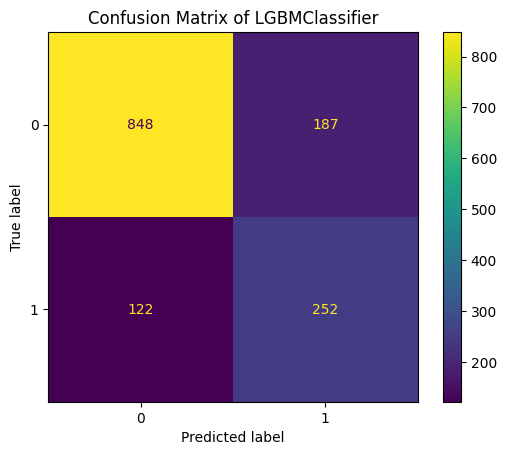

In [52]:
y_pred = [1 if prob > thresholds[ix] else 0 for prob in y_pred_proba[:,1]]
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
cmp.plot()
plt.title(f"Confusion Matrix of {model.__class__.__name__}")
plt.show()

In [53]:
print(f"""
Recalls: {recall_score(y_test, y_pred):.3f}
Precision: {precision_score(y_test, y_pred):.3f}
F1 Score: {f1_score(y_test, y_pred):.3f}
ROC AUC SCORE: {roc_auc_score(y_test, y_pred):.3f}
""")    


Recalls: 0.674
Precision: 0.574
F1 Score: 0.620
ROC AUC SCORE: 0.747



In [54]:
test = pd.read_csv("../data/processed/test_data_id.csv")
test["Churn"] = y_pred
test = test.merge(df_ori, on='Customer ID', how='left')
# test.to_csv("../data/processed/test_data.csv", index=False)
test.to_excel("../data/processed/test_data_excel.xlsx", index=False)

c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\923006079\AppData\Local\anaconda3\envs\forecasting-tools\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

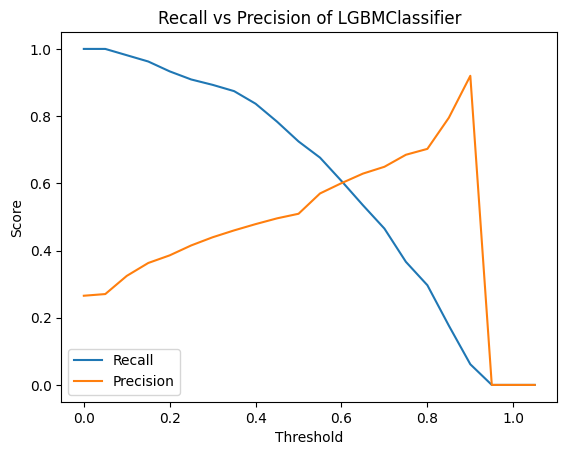

In [49]:
thresholds = np.arange(0, 1.1, 0.05)

recalls = []
precisions = []

for threshold in thresholds:
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_proba[:,1]]
    recalls.append(recall_score(y_test, y_pred))
    precisions.append(precision_score(y_test, y_pred))

sns.lineplot(x=thresholds, y=recalls, label="Recall")
sns.lineplot(x=thresholds, y=precisions, label="Precision")
plt.title(f"Recall vs Precision of {model.__class__.__name__}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

# Reconsideration
When it comes to presenting the results to the management, they want to be able to target actual churned customers that has high CLTV.

In [239]:
pair_model_params = [
    (GradientBoostingClassifier,{
        "learning_rate": 0.004168626628161481,
        "n_estimators": 300,
        "subsample": 0.421084339636955,
        "min_samples_split": 160,
        "min_samples_leaf": 169,
        "random_state": 42

    }),
    (RandomForestClassifier,{
        "max_depth": 5,
        "min_samples_split": 100,
        "min_samples_leaf": 50,
        "n_estimators": 400,
        "max_samples": 0.8,
        "max_features": 19,
        "random_state": 42

    }),
    (cb.CatBoostClassifier, {
        "objective": "Logloss",
        "colsample_bylevel": 0.019279784889392193,
        "depth": 11,
        "boosting_type": "Ordered",
        "bootstrap_type": "Bernoulli",
        "subsample": 0.3888083284876748,
        "random_state": 42
    }),
    (xgb.XGBClassifier, {
        "booster": "dart",
        "lambda": 3.0801253103282232e-06,
        "alpha": 1.3262277792817022e-06,
        "subsample": 0.5110951421384241,
        "colsample_bytree": 0.32513183823053105,
        "max_depth": 5,
        "min_child_weight": 8,
        "eta": 1.3731340344885955e-06,
        "gamma": 0.00030449033067205217,
        "grow_policy": "lossguide",
        "sample_type": "weighted",
        "normalize_type": "tree",
        "rate_drop": 1.9993069089328354e-06,
        "skip_drop": 0.016858563281265018,
        "random_state": 42
    }),
    (lgb.LGBMClassifier, {
        "lambda_l1": 4.9087660802805254e-08,
        "lambda_l2": 7.107814046559069e-08,
        "num_leaves": 3,
        "feature_fraction": 0.4386219301785611,
        "bagging_fraction": 0.5853318649736283,
        "bagging_freq": 1,
        "min_child_samples": 200,
        "random_state": 42
    })
]

Learning rate set to 0.025403
0:	learn: 0.6931472	total: 10.9ms	remaining: 10.9s
1:	learn: 0.6931472	total: 17.5ms	remaining: 8.74s
2:	learn: 0.6846571	total: 29.4ms	remaining: 9.77s
3:	learn: 0.6846571	total: 37.1ms	remaining: 9.24s
4:	learn: 0.6846571	total: 45.3ms	remaining: 9.01s
5:	learn: 0.6818575	total: 57.6ms	remaining: 9.55s
6:	learn: 0.6803650	total: 70ms	remaining: 9.93s
7:	learn: 0.6770728	total: 76.3ms	remaining: 9.46s
8:	learn: 0.6770728	total: 83ms	remaining: 9.14s
9:	learn: 0.6770727	total: 91.5ms	remaining: 9.05s
10:	learn: 0.6770727	total: 96.7ms	remaining: 8.69s
11:	learn: 0.6770727	total: 103ms	remaining: 8.51s
12:	learn: 0.6770727	total: 109ms	remaining: 8.25s
13:	learn: 0.6770727	total: 114ms	remaining: 8.03s
14:	learn: 0.6770727	total: 121ms	remaining: 7.96s
15:	learn: 0.6754352	total: 127ms	remaining: 7.81s
16:	learn: 0.6754352	total: 134ms	remaining: 7.73s
17:	learn: 0.6754352	total: 139ms	remaining: 7.59s
18:	learn: 0.6754352	total: 144ms	remaining: 7.46s
19:	

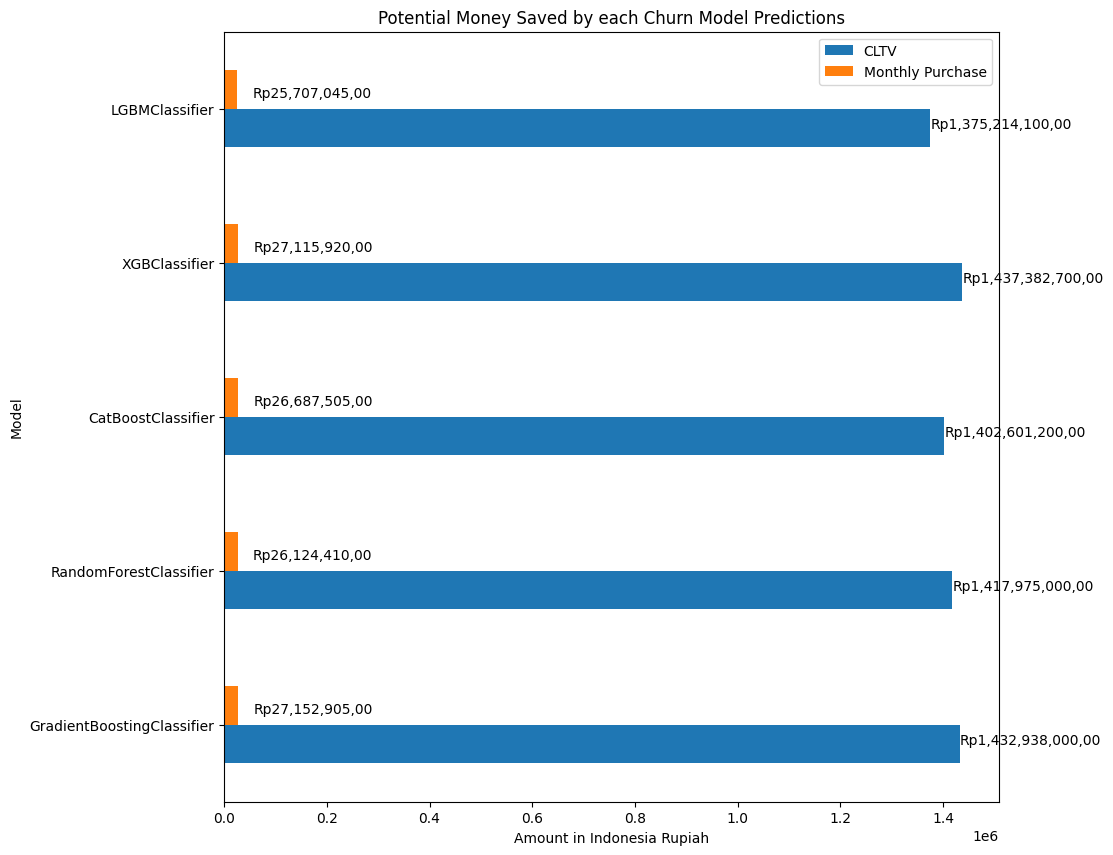

In [240]:
X_train, X_test, y_train, y_test = data_preparation(df_ori)

models = []
cltvs = []
monthly_purchase = []
for (model, params) in pair_model_params:
    # Create Best Model
    # ==============================================
    model = model(**params)
    model.fit(X_train, y_train)

    # Predict using threshold 0.5
    # ==============================================
    y_pred_proba = model.predict_proba(X_test)
    y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_proba[:,1]]

    # Calculate CLTV
    # ==============================================
    df = df_ori.copy()
    potentially_saved_money = df.iloc[y_test[(y_pred == y_test) & (y_test==1)].index, -1].sum()
    models.append(model.__class__.__name__)
    cltvs.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "CLTV (Predicted Thou. IDR)"].sum())
    monthly_purchase.append(df.loc[y_test[(y_pred == y_test) & (y_test==1)].index, "Monthly Purchase (Thou. IDR)"].sum())

ax = pd.DataFrame({    
    "Model": models,
    "CLTV": cltvs,
    "Monthly Purchase": monthly_purchase,
    }).set_index("Model").plot.barh(figsize=(10, 10))

# Adding annotations to the bars
for i, v in enumerate(cltvs):
    ax.text(v + 3, i-0.1, f"Rp{v*1000:,.0f},00", va='center')

for i, v in enumerate(monthly_purchase):
    ax.text(v + 3 * 10000, i+0.1, f"Rp{v*1000:,.0f},00", color='black', va='center')

plt.xlabel("Amount in Indonesia Rupiah")
plt.title("Potential Money Saved by each Churn Model Predictions")
plt.show()